In [1]:
import QUANTAXIS as QA
try:
    assert QA.__version__>='1.1.0'
except AssertionError:
    print('pip install QUANTAXIS >= 1.1.0 请升级QUANTAXIS后再运行此示例')
    import QUANTAXIS as QA 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import abupy
from abupy import ABuRegUtil
from concurrent.futures import ThreadPoolExecutor
from functools import reduce
import warnings

def amountAnalyse(buydata):
    """
    @buydata as pdDataFrame
    e.g. buydata = QA.QA_fetch_get_stock_transaction_realtime('pytdx','600797') get current day's transaction
    e.g. data1=QA.QAFetch.QATdx.QA_fetch_get_stock_transaction('600797','2019-01-01','2019-04-11') get transaction among period of time
    
    """
    sellone = buydata[buydata['buyorsell']==1]
    sellone['amount'] = sellone['price']*sellone['vol']
    sellone.sort_values("vol",inplace=True,ascending=False)

    buyone = buydata[buydata['buyorsell']==0]
    buyone['amount'] = buyone['price']*buyone['vol']
    buyone.sort_values("vol",inplace=True,ascending=False)
    #print("Top buyer vol")
    #buyone[buyone['vol']>10]
    print("Top Seller vol")
    sellone.head(100)
def getStocklist():
    """
    get all stock as list 
    usage as: 
    QA.QA_util_log_info('GET STOCK LIST')
    stocks=getStocklist()
    """
    data=QA.QAFetch.QATdx.QA_fetch_get_stock_list('stock')
    stock = data['code'].index
    stocklist = []
    for code in stock:
        stocklist.append(code[0])
    return stocklist
def loadLocalData(stocks,start_date ='2018-03-15',end_date = '2019-09-07'):
    """
    data() as pdDataFrame
    stocks could be list of all the stock or some. if you pass single one e.g. 000001 it will get one only
    to get dedicated stock, using below method, and notice stockp() will be dataFrame
    stockp = data.select_code(stock)
    
    
    """
    QA.QA_util_log_info('load data from local DB')
    data=QA.QA_fetch_stock_day_adv(stocks,start_date,end_date)
    return data
def loadFromCopy(file):
    """
    loaddata from file copy
    """
    return pd.DataFrame(pd.read_csv(file))

def calAngle(df):
    """
    trend angle based on provided dataframe 
    """
    return ABuRegUtil.calc_regress_deg(df.close.values,show=False)

def getData(df, code):
    """
    split data per code from all market data 
    """
    return df[df.code==code].reset_index(drop=True)


def execute(stocks,data): 
    select=[]
    for stock in stocks: 
        try:
            QA.QA_util_log_info('dealting with {}'.format(stock))
            stockp = data.select_code(stock)
            if (trend(stockp[-10:])>0 and trend(stockp[-10:])<10):
                select.append(stock)
        except:
            print('wrong with {}'.format(stock))

    return sorted(select)[-2:]


def executeParallel(stocks,data): 
    """
    scan all data and filter out ones doing trendbreak
    """
    alldep=[]
    with ThreadPoolExecutor(5) as executor:
        for stock , dep in zip(stocks,executor.map(trendSingle,alldata)):
            alldep.append((stock,dep))
    print('all done')          
    return alldep
def init_change(df):
    #change first (d[i].close-d[i-1].close)/d[i-1].close
    pp_array = [float(close) for close in df.close]
    temp_array = [(price1, price2) for price1,price2 in zip(pp_array[:-1],pp_array[1:])]
    change = list(map(lambda pp: reduce(lambda a, b: round((b - a) / a, 3), pp), temp_array))
    change.insert(0,0)
    df['change'] = change
    #amplitude (d[i].high-d[i].low)/d[i-1].close) 
    amp_arry=[float(amp) for amp in (df.high-df.low)]
    amp_temp =  [(price1, price2) for price1,price2 in zip(amp_arry[:-1],pp_array[1:])]
    amplitude = list(map(lambda pp: reduce(lambda a, b: round(a/b, 3), pp), amp_temp))
    amplitude.insert(0,0)
    df['amplitude'] = amplitude
    sratio = QA.QA_fetch_get_stock_info(df.index.get_level_values('code')[0]).liutongguben[0]
    df['SR']=df['volume']/sratio*100
    
    
def init_trend(df,period=5):
    """
    period can be set based on situation. 
    detect the angle change form negative to positive 
    """
    trend=[]
    ratio = []
    for i in range(0,df.shape[0]):
        #print(i)
        if(i<period):
            #trend.append(calAngle(df.iloc[:period]))
            ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
        else:
            #trend.append(calAngle(df.iloc[i-period+1:i+1]))
            ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
    df['trend']=trend
    df['amountRatio'] = ratio
    
    
def trendBreak(pdDataFrame):
    from abupy import pd_rolling_max
    from abupy import pd_expanding_max
    # 当天收盘价格超过N1天内最高价格作为买入信号
    N1 = 20
    # 当天收盘价格超过N2天内最低价格作为卖出信号
    N2 = 15
    kl_pd = pdDataFrame
    # 通过rolling_max方法计算最近N1个交易日的最高价
    # kl_pd['n1_high'] = pd.rolling_max(kl_pd['high'], window=N1)
    kl_pd['n1_high'] = pd_rolling_max(kl_pd['high'], window=N1)
    # 表7-4所示

    # expanding_max
    # expan_max = pd.expanding_max(kl_pd['close'])
    expan_max = pd_expanding_max(kl_pd['close'])
    # fillna使用序列对应的expan_max
    kl_pd['n1_high'].fillna(value=expan_max, inplace=True)
    # 表7-5所示
    #print('kl_pd[0:5]:\n', kl_pd[0:5])

    from abupy import pd_rolling_min, pd_expanding_min
    # 通过rolling_min方法计算最近N2个交易日的最低价格
    # rolling_min与rolling_max类似
    # kl_pd['n2_low'] = pd.rolling_min(kl_pd['low'], window=N2)
    kl_pd['n2_low'] = pd_rolling_min(kl_pd['low'], window=N2)
    # expanding_min与expanding_max类似
    # expan_min = pd.expanding_min(kl_pd['close'])
    expan_min = pd_expanding_min(kl_pd['close'])
    # fillna使用序列对应的eexpan_min
    kl_pd['n2_low'].fillna(value=expan_min, inplace=True)

    # 当天收盘价格超过N天内的最高价或最低价, 超过最高价格作为买入信号买入股票持有
    buy_index = kl_pd[kl_pd['close'] > kl_pd['n1_high'].shift(1)].index
    kl_pd.loc[buy_index, 'sig'] = 1

    # 当天收盘价格超过N天内的最高价或最低价, 超过最低价格作为卖出信号
    sell_index = kl_pd[kl_pd['close'] < kl_pd['n2_low'].shift(1)].index
    kl_pd.loc[sell_index, 'sig'] = 0

    #kl_pd.signal.value_counts().plot(kind='pie', figsize=(5, 5))
    #plt.show()

    """
        将信号操作序列移动一个单位，代表第二天再将操作信号执行，转换得到持股状态
        这里不shift(1)也可以，代表信号产生当天执行，但是由于收盘价格是在收盘后
        才确定的，计算突破使用了收盘价格，所以使用shift(1)更接近真实情况
    """
    kl_pd['keep'] = kl_pd['sig'].shift(1)
    kl_pd['keep'].fillna(method='ffill', inplace=True)
   
    kl_pd.fillna(0, inplace = True)
    keList = kl_pd.keep.to_list()
    size = len(keList)
    single=[0]
    for i in range(1,size):
        if(keList[i-1]==0 and keList[i]==1):
            single.append(1)
            continue
        if(keList[i-1]==1 and keList[i]==1):
            single.append(0)
            continue
        if(keList[i-1]==1 and keList[i]==0):
            single.append(3)
            continue
        if(keList[i-1]==0 and keList[i]==0):
            single.append(0)
    #print("length "+str(len(single)))     
    kl_pd['single']=single       
            
    return kl_pd
    #set up buy and sell single 
    """
    keep = 10
    profit = 0.1
    single = [0,0]
    for i in range(2,kl_pd.shape[0]):
        if(kl_pd.iloc[i-2].oper == 1 and kl_pd.iloc[i-1].oper==1 and kl_pd.iloc[i].amountRatio<1):
            single.append(1)
        else:
            single.append(0)
    kl_pd['single']=single
    """   
    
    return kl_pd

    # 计算基准收益
    #kl_pd['benchmark_profit'] = np.log(
        #kl_pd['close'] / kl_pd['close'].shift(1))

    # 计算使用趋势突破策略的收益
    #kl_pd['trend_profit'] = kl_pd['keep'] * kl_pd['benchmark_profit']

    # 可视化收益的情况对比
    #kl_pd[['benchmark_profit', 'trend_profit']].cumsum().plot(grid=True,
        #                                                      figsize=(
        #                                                          14, 7))
    #plt.show()
    #kl_pd[['n2_low','n1_high','close']].plot(grid=True,figsize=(14,7))
    #kl_pd.close.plot(grid=True,figsize=(14.7))
    #plt.show()

"""

def trendSingle(df):
   
    buydate=[]
    for i in range(0,df.shape[0]):
        if(df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude<0.07 and df.iloc[i].change<0.03 
          and df.iloc[i].change>0.01):
            buydate.append((i,df.iloc[i].date))
    return buydate
"""

def trendSingle(df):
    """
    @paramater dataframe 
    return True or False
    Justification:
    1. latest 20 days angle >0
    2. chagne (0.1~0.3)
    3. 
    
    """
    keep = 3
    init_change(df)
    init_trend(df)
    single=[]
    for i in range(0,df.shape[0]):
        if(1.5>df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude>0.05 
           and 0.01<df.iloc[i].change<0.03 and df.iloc[i].SR <0.05):
            single.append(1)
        else:
            single.append(0)
    single=single[1:]
    single.insert(0,0)
    for i in range(0,len(single)):
        if single[i] == 1:
            #set the sell date
            keep = 3
            j = i 
            while(keep):
                if j+1<len(single) and df.iloc[j+1].close<df.iloc[j].close:
                #drop then sell
                    single[j+1]=3
                    break
                elif j+1 < len(single) and df.iloc[j+1].close >df.iloc[j].close:
                    single[j+1] = 0  # if keep the changel also the possible buy to 0 
                #raise then keep one more day
                
                    keep -=1 
                    j = j + 1
            if(keep == 0):
                single[i+3] = 3    
    df['single']=single
    #df['single']=df['keep'].shift(1)
    #df['single'].fillna(method='ffill',inplace=True)
    return df

def detect(df): 
    init_change(df)
    init_trend(df)
    if(1.5> df.iloc[-1].amountRatio>1 and df.iloc[-1].trend>1 and df.iloc[-1].amplitude>0.05
       and 0.01<df.iloc[-1].change<0.03 ):
        return True
    else: 
        return False 
    
    


In [1]:
pow(1.04,8)

1.3685690504052739

In [144]:
codelist=['000977']
    #codelist = QA.QA_fetch_stock_block_adv().get_block('云计算').code[30:60]
    #data=QA.QA_fetch_stock_day_adv(codelist,'2018-01-01','2019-09-04')
data = loadLocalData(codelist,'2018-01-01','2019-09-11')
trendBreak(data.data)
data.data[-20:]


QUANTAXIS>> load data from local DB
load data from local DB


,,open,high,low,close,volume,amount,n1_high,n2_low,sig,keep,single
date,code,,,,,,,,,,,
2019-08-15,000977,19.48,20.62,19.37,20.61,350808.0,7.0589e+08,21.70,19.37,0.0,0.0,0
2019-08-16,000977,20.52,22.32,20.40,22.01,710681.0,1.5320e+09,22.32,19.37,1.0,0.0,0
2019-08-19,000977,22.79,24.21,22.78,24.21,785392.0,1.8563e+09,24.21,19.37,1.0,1.0,1
2019-08-20,000977,24.71,24.89,24.22,24.63,843746.0,2.0738e+09,24.89,19.37,1.0,1.0,0
2019-08-21,000977,24.53,25.11,24.31,24.71,553034.0,1.3684e+09,25.11,19.37,0.0,1.0,0
2019-08-22,000977,24.73,25.10,24.47,24.82,433557.0,1.0755e+09,25.11,19.37,0.0,1.0,0
2019-08-23,000977,24.90,25.82,24.82,25.06,608248.0,1.5411e+09,25.82,19.37,0.0,1.0,0
2019-08-26,000977,24.55,25.31,24.13,24.40,518511.0,1.2743e+09,25.82,19.37,0.0,1.0,0
2019-08-27,000977,25.03,26.06,24.80,25.49,704303.0,1.7936e+09,26.06,19.37,0.0,1.0,0


****************************************************************************************************
loading data
****************************************************************************************************
init account


QUANTAXIS>> load data from local DB
load data from local DB


****************************************************************************************************
prepare data for back test
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-01-03 00:00:00 buy 300548
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-01-04 00:00:00 buy 000625
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-01-04 00:00:00 buy 600734
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-01-07 00:00:00 buy 300322
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
************************************************************************************

ERROR : CODE 002889 TIME 2019-06-04 00:00:00  AMOUNT 0 TOWARDS 1
None
ERROR : CODE 002281 TIME 2019-06-05 00:00:00  AMOUNT 0 TOWARDS 1
None
ERROR : CODE 002792 TIME 2019-06-05 00:00:00  AMOUNT 0 TOWARDS 1
None
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-06-06 00:00:00 buy 002194
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-06-06 00:00:00 buy 002369
ERROR : CODE 002927 TIME 2019-06-06 00:00:00  AMOUNT 0 TOWARDS 1
None
ERROR : CODE 300134 TIME 2019-06-06 00:00:00  AMOUNT 0 TOWARDS 1
None
ERROR : CODE 300538 TIME 2019-06-06 00:00:00  AMOUNT 0 TOWARDS 1
None
ERROR : CODE 300736 TIME 2019-06-10 00:00:00  AMOUNT 0 TOWARDS 1
None
ERROR : CODE 002405 TIME 2019-06-11 00:00:00  AMOUNT 0 TOWARDS 1
None
ERROR : CODE 002897 TIME 2019-06-12 00:00:00  AMOUNT 0 TOWARDS 1
None
ER

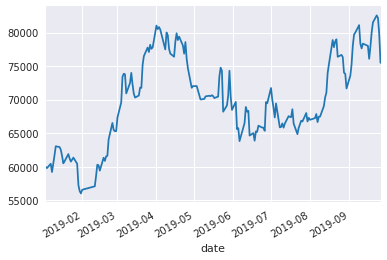

In [2]:
if __name__ == '__main__':
    print('*'*100)
    print('loading data')
    #stockes = getStocklist()
    #stockes = ['600797','000977']
    #data = loadLocalData(stockes,'2018-03-15',end_date = '2019-09-11')
    print('*'*100)
    print('init account')
    Account=QA.QA_Account(user_cookie='eric',portfolio_cookie='eric')
    Broker=QA.QA_BacktestBroker()
    Account.reset_assets(60000)
    Account.account_cookie='ECAP'
    #codelist=['600797','000977','601068','601069','000977']
    #codelist = QA.QA_fetch_stock_block_adv().get_block('云计算').code[:]
    codelist = QA.QA_fetch_stock_block_adv().get_block('华为概念').code[:]
    #data=QA.QA_fetch_stock_day_adv(codelist,'2018-01-01','2019-09-04')
    data = loadLocalData(codelist,'2018-01-01','2019-09-26')
    data=data.to_qfq()
    print('*'*100)
    print('prepare data for back test')
    
    
    ind=data.add_func(trendBreak)
    data_forbacktest=data.select_time('2019-01-01','2019-09-26')


    for items in data_forbacktest.panel_gen:
        for item in items.security_gen:
        
            daily_ind=ind.loc[item.index]
        #print(daily_ind)
            if (daily_ind.single.iloc[0] == 1):
                if((Account.cash_available-2000)/(2*item.open[0]) > 0):
                    order=Account.send_order(
                        code=item.code[0], 
                        time=item.date[0], 
                        amount=int((Account.cash_available-5000)/(2*item.open[0])), 
                    #amount = 2000,
                #amount=2000,
                        towards=QA.ORDER_DIRECTION.BUY, 
                        price=item.open[0], 
                        order_model=QA.ORDER_MODEL.CLOSE, 
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        )
                else: 
                    order=Account.send_order(
                        code=item.code[0], 
                        time=item.date[0], 
                        amount=int((Account.cash_available-5000)/item.open[0]), 
                    #amount = 2000,
                #amount=2000,
                        towards=QA.ORDER_DIRECTION.BUY, 
                        price=item.open[0], 
                        order_model=QA.ORDER_MODEL.CLOSE, 
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        )
            #print(item.to_json()[0])
                if order: 
                #print('sending order '+'*'*60)
                    Broker.receive_order(QA.QA_Event(order=order,market_data=item))
            
            
                    trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                    res=trade_mes.loc[order.account_cookie,order.realorder_id]
                    #print(trade_mes)
                    order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
                    print('*'*100)
                    print(str(item.date[0])+" buy "+item.code[0])
                #print (res)
            elif (daily_ind.single.iloc[0] == 3 ) :        
                if Account.sell_available.get(item.code[0], 0)>0:
                    print('>'*100)
                    print(str(item.date[0])+" sell "+ item.code[0])
                #print(int(Account.sell_available.get(item.code[0], 0)))
                    order=Account.send_order(
                        code=item.code[0], 
                        time=item.date[0], 
                        
                        
                        
                        
                        
                        amount=Account.sell_available.get(item.code[0], 0), 
                        towards=QA.ORDER_DIRECTION.SELL, 
                        price=item.close[0], 
                        order_model=QA.ORDER_MODEL.MARKET, 
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                        )
                    if order: 
                        Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                        trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                        res=trade_mes.loc[order.account_cookie,order.realorder_id]
                        order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
                #print(res)
        Account.settle()
        
    print('*'*100)
    print('analyse account profit')
    Risk=QA.QA_Risk(Account)
    Risk.assets.plot()
    print(Risk.profit_construct) 


In [51]:
data=QA.QAFetch.QATdx.QA_fetch_get_stock_list('stock')

## data = QA.QAFetch.QATdx.QA_fetch_get_stock_block().blockname

In [106]:
stockInTrade = QA.QA_fetch_get_stock_info('600797').liutongguben[0]
data = loadLocalData('600797','2018-01-01','2019-09-11')


QUANTAXIS>> load data from local DB
load data from local DB


In [73]:
data.data['SR']=data.data['amount']/(stockInTrade*3.6163793103448283)

In [107]:
code = data.data.index.get_level_values('code')[0]

In [117]:
data.data['SRatio']=data.data['volume']/QA.QA_fetch_get_stock_info(code).liutongguben[0]*100

In [125]:
data.data

open     high      low    close       volume  \
date       code                                                      
2019-01-02 000977  15.8835  15.9334  15.5642  15.8037  254040.2159   
           600797   7.2456   7.2755   7.1559   7.2755   45413.2231   
           601068   5.2051   5.2648   5.1453   5.2051  125590.9723   
           601069  14.7897  14.8397  13.3707  14.0003  131172.1551   
2019-01-03 000977  15.7937  16.0232  15.4844  15.4944  238872.4541   
           600797   7.2058   7.3553   7.2058   7.2357   62451.3341   
           601068   5.1652   5.2548   5.0856   5.1553  142095.6871   
           601069  13.8504  14.5399  13.6005  14.3800  119204.8387   
2019-01-04 000977  15.2550  16.1928  15.1751  16.1230  354798.1356   
           600797   7.1161   7.5347   7.0862   7.4848  113212.4832   
...                    ...      ...      ...      ...          ...   
2019-09-09 601068   6.2900   6.4300   6.2300   6.3400  222095.0000   
           601069  17.0100  17.3600  16.9000  17.3300  313136.0000   
2019-09-10 000977  28.1000  28.1200  26.3000  26.9700  510685.0000   
           600797   9.4200   9.4200   9.1300   9.2100  356345.0000   
           601068   6.3100   6.3600   6.2400   6.2900  158529.0000   
           601069  17.1600  17.5400  17.0100  17.3400  273868.0000   
2019-09-11 000977  27.0000  27.5200  26.6200  26.6800  356212.0000   
           600797   9.2300   9.3200   9.0800   9.1100  235883.0000   
           601068   6.3300   6.4200   6.2300   6.3500  234953.0000   
           601069  17.2900  17.4400  16.9400  16.9800  310994.0000   

                       amount  preclose     adj  
date       code                                  
2019-01-02 000977  4.0058e+08       NaN  0.9977  
           600797  3.2838e+07       NaN  0.9966  
           601068  6.5401e+07       NaN  0.9952  
           601069  1.8394e+08       NaN  0.9993  
2019-01-03 000977  3.7620e+08   15.8037  0.9977  
           600797  4.5441e+07    7.2755  0.9966  
           601068  7.3555e+07    5.2051  0.9952  
           601069  1.6830e+08   14.0003  0.9993  
2019-01-04 000977  5.6158e+08   15.4944  0.9977  
           600797  8.3578e+07    7.2357  0.9966  
...                       ...       ...     ...  
2019-09-09 601068  1.4025e+08    6.2100  1.0000  
           601069  5.3830e+08   16.9400  1.0000  
2019-09-10 000977  1.3814e+09   27.8000  1.0000  
           600797  3.2929e+08    9.4200  1.0000  
           601068  9.9594e+07    6.3400  1.0000  
           601069  4.7312e+08   17.3300  1.0000  
2019-09-11 000977  9.6392e+08   26.9700  1.0000  
           600797  2.1625e+08    9.2100  1.0000  
           601068  1.4880e+08    6.2900  1.0000  
           601069  5.3410e+08   17.3400  1.0000  

[684 rows x 8 columns]

In [112]:
QA.QA_fetch_get_stock_info('600797')

,market,code,liutongguben,province,industry,updated_date,ipo_date,zongguben,guojiagu,faqirenfarengu,...,touzishouyu,jingyingxianjinliu,zongxianjinliu,cunhuo,lirunzonghe,shuihoulirun,jinglirun,weifenpeilirun,meigujingzichan,baoliu2
0,1,600797,1.0238e+09,28,24,20190911,19970418,1.0466e+09,1.6870e+09,9.2802e+08,...,3.4446e+08,-2.0238e+09,-1.5069e+09,4.2599e+09,1.2310e+09,1.0800e+09,1.0815e+09,1.2516e+10,4.296,6.0


In [151]:
Account.history_table

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message,frozen
0,2019-01-04 00:00:00,000066,4.92,10000,50787.7000,Order_Abhg63ay,Order_Abhg63ay,Trade_gzcZeqjt,ECAP,12.3000,0.000,None,0
1,2019-01-04 00:00:00,000070,7.85,3300,24876.2237,Order_5fUYHiEQ,Order_5fUYHiEQ,Trade_Z7C93Oqr,ECAP,6.4763,0.000,None,0
2,2019-01-04 00:00:00,000100,2.51,4000,14831.2237,Order_0LOGfRmy,Order_0LOGfRmy,Trade_nvzEY17q,ECAP,5.0000,0.000,None,0
3,2019-01-04 00:00:00,000555,9.78,500,9936.2237,Order_Ir6CvSFM,Order_Ir6CvSFM,Trade_ENfCBPgM,ECAP,5.0000,0.000,None,0
4,2019-01-04 00:00:00,000611,6.21,400,7447.2237,Order_45du1AjT,Order_45du1AjT,Trade_h9kUImjR,ECAP,5.0000,0.000,None,0
5,2019-01-04 00:00:00,002197,7.07,100,6735.2237,Order_kHvoJtSL,Order_kHvoJtSL,Trade_VC4y7kNd,ECAP,5.0000,0.000,None,0
6,2019-01-04 00:00:00,002232,7.29,100,6001.2237,Order_inIsCtBm,Order_inIsCtBm,Trade_whvbf6OP,ECAP,5.0000,0.000,None,0
7,2019-01-04 00:00:00,002467,3.10,100,5686.2237,Order_Hf251AaV,Order_Hf251AaV,Trade_5y2zgba4,ECAP,5.0000,0.000,None,0
8,2019-01-04 00:00:00,600289,2.70,100,5411.2237,Order_RCnX8S6a,Order_RCnX8S6a,Trade_sA0f6QXF,ECAP,5.0000,0.000,None,0
9,2019-01-04 00:00:00,600595,2.01,100,5205.2237,Order_hTmgnLtd,Order_hTmgnLtd,Trade_63Yia4EM,ECAP,5.0000,0.000,None,0


In [70]:
8.39/2.32

3.6163793103448283

In [126]:
ind.xs(codelist[-1],level=1)['2019-01'][:]

,open,high,low,close,volume,amount,preclose,adj,change,amplitude,SR,trend,amountRatio,single
date,,,,,,,,,,,,,,
2019-01-02,15.8835,15.9334,15.5642,15.8037,254040.2159,4.0058e+08,NaN,0.9977,0.000,0.000,0.0197,1.5655,0.8824,0
2019-01-03,15.7937,16.0232,15.4844,15.4944,238872.4541,3.7620e+08,15.8037,0.9977,-0.020,0.024,0.0185,1.5655,0.8287,0
2019-01-04,15.2550,16.1928,15.1751,16.1230,354798.1356,5.6158e+08,15.4944,0.9977,0.041,0.033,0.0275,1.5655,1.2371,0
2019-01-07,16.1329,16.5121,16.0631,16.4323,360228.5812,5.8835e+08,16.1230,0.9977,0.019,0.062,0.0279,1.5655,1.2960,1
2019-01-08,16.3624,16.4821,16.1030,16.2128,218036.7022,3.5471e+08,16.4323,0.9977,-0.013,0.028,0.0169,1.5655,0.7814,3
2019-01-09,16.2626,16.6917,16.1030,16.3026,306889.3369,5.0348e+08,16.2128,0.9977,0.006,0.023,0.0238,1.5655,1.1091,0
2019-01-10,16.2427,16.3923,15.8735,15.9334,242668.1532,3.9282e+08,16.3026,0.9977,-0.023,0.037,0.0188,1.5655,0.8653,0
2019-01-11,15.9633,16.2726,15.8935,16.0731,225631.1072,3.6263e+08,15.9334,0.9977,0.009,0.032,0.0175,0.9169,0.7552,0
2019-01-14,16.0930,16.1130,15.7139,15.7638,173779.2718,2.7552e+08,16.0731,0.9977,-0.019,0.024,0.0135,-1.5505,0.6256,0


In [44]:
test = [1,2,3,4,5,6,7,8,9]


In [31]:
len(test)

9

In [37]:
for i in range(0,len(test)):
    print(i)

0
1
2
3
4
5
6
7
8


In [45]:
test[-4:]=[0,0,0,0]

In [46]:
test

[1, 2, 3, 4, 5, 0, 0, 0, 0]

In [24]:
test

[1, 0, 0, 0]

In [27]:
test[0]=test[0]

In [28]:
test

[1, 0, 0, 0]

In [4]:
def maxfind(nums):
    size = len(nums)
    maxn = 0
    tempmax = 0
    for i in range(0,size):
        if(tempmax<=0):
            tempmax = nums[i]
        else:
            tempmax +=nums[i]
        if(tempmax>maxn):
            maxn = tempmax 
    return maxn

test = [1, -1, 2]

In [7]:
maxfind([1,2,-1,4,6,-5])

12

In [39]:
def addBinary(a: str, b: str) -> str:
        ans, extra = '',0 
        i,j=len(a)-1,len(b)-1
        while i>=0 or j>=0:
            if i >= 0:
                print('dealing with '+a[i])
                extra += ord(a[i]) - ord('0')
            if j >= 0:
                print('doing with '+b[j])
                extra += ord(b[j]) - ord('0')
            print("got "+str(extra%2)+" and adding more to next ")
            ans += str(extra % 2)
            extra //= 2
            i,j = i-1,j-1
       
        if extra == 1:
            ans += '1'
        print('final is ans '+ans)
        return ans[::-1]

In [40]:
addBinary('1001','101')

dealing with 1
doing with 1
got 0 and adding more to next 
dealing with 0
doing with 0
got 1 and adding more to next 
dealing with 0
doing with 1
got 1 and adding more to next 
dealing with 1
got 1 and adding more to next 
final is ans 0111


'1110'

In [41]:
a = [1,1,22,3,4,5]
b = a[::-1]
b

[5, 4, 3, 22, 1, 1]

In [12]:
ord('1')

49

In [13]:
2%2


0

In [14]:
2/2

1.0

In [15]:
extra = 2
extra //=2

In [16]:
extra


1

In [17]:
extra = 2
extra =extra /2 

In [22]:
a = '1010'
a += '1'

In [19]:
if extra == 1:
    print ('got ')

got 


In [25]:
a = '110'
i = len(a)-1
while i>=0:
    print(a[i])
    i = i-1

0
1
1


In [51]:
def climib(n):
    if(n ==1):
        return 1
    dp = []
    dp.append(0)
    dp.append(1)
    dp.append(2)
    for i in range(3,n+1):
        dp.append(dp[i-1]+dp[i-2])
    return dp
       

In [52]:
m = climib(10)

In [53]:
for i in m:
    print(i)

0
1
2
3
5
8
13
21
34
55
89


In [56]:
def leaveOnlyOne(dp):
    if(len(dp) == 1):
        return dp 
    stack = []
    stack.append(dp[0])
    for i in range(1,len(dp)):
        top = stack[-1]
        if(top != dp[i]):
            stack.append(dp[i])
    return stack 


        

In [59]:
dp = [1,2,2,2,2,3,3]
m = leaveOnlyOne(dp)
m

[1, 2, 3]

In [60]:
b = [1,2,3]
c= [2,4,8]
b.extend(c)
m = sorted(b)

In [61]:
m

[1, 2, 2, 3, 4, 8]